In [1]:
%matplotlib inline


In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from astropy.stats import BoxLeastSquares


In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)

0.1.4
1.0.4
3.6


In [4]:
target = 'l 98-59'
tpf = lightkurve.search_targetpixelfile(target).download()

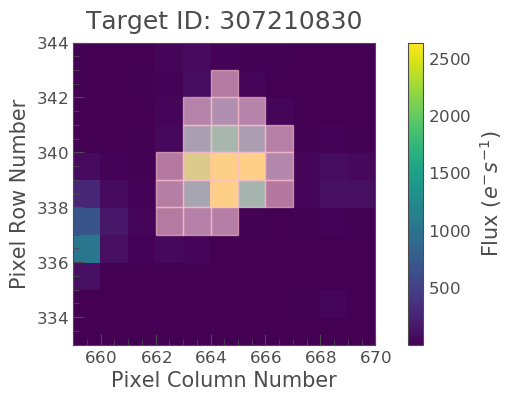

In [5]:
texp = tpf.hdu[1].header['FRAMETIM'] * tpf.hdu[1].header["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
ref_time = 0.5 * (tpf.time.min() + tpf.time.max())
flux = tpf.flux

pix_mask = tpf.create_threshold_mask(threshold=3)
tpf.plot(aperture_mask=pix_mask, )
plt.gcf().savefig('pixmask.pdf', dpi=200)

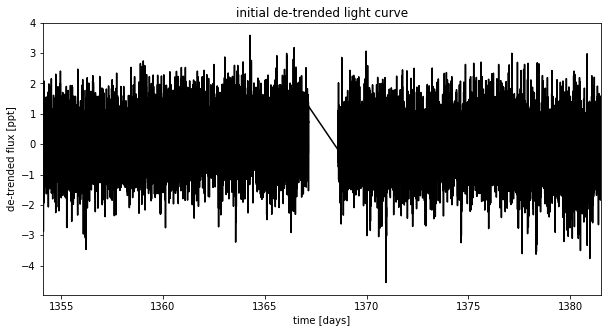

In [6]:
lc = tpf.extract_aperture_photometry(aperture_mask=pix_mask, )
lc = lc.normalize()
lc.flux = (lc.flux - 1.0) * 1e3
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, lc.flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(lc.time, lc.flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(lc.time.min(), lc.time.max());

In [7]:
period_grid = np.exp(np.linspace(np.log(0.1), np.log(15), 50000))
duration = 0.03

bls_periods = np.zeros([3])
bls_t0s = np.zeros([3])
bls_depths = np.zeros([3])
time = lc.time - ref_time

# planet 1
bls = BoxLeastSquares(time, lc.flux - pld_flux)
bls_power = bls.power(period_grid, duration, oversample=20)

bls_power0 = bls_power

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 3*duration, bls_t0)

bls_periods[0] = bls_period
bls_t0s[0] = bls_t0
bls_depths[0] = bls_depth

# planet 2
bls = BoxLeastSquares(time[~transit_mask], lc.flux[~transit_mask] - pld_flux[~transit_mask])
bls_power = bls.power(period_grid, duration, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

bls_periods[1] = bls_period
bls_t0s[1] = bls_t0
bls_depths[1] = bls_depth

# planet 3
bls = BoxLeastSquares(time[~transit_mask], lc.flux[~transit_mask] - pld_flux[~transit_mask])
bls_power = bls.power(period_grid, duration, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

bls_periods[2] = bls_period
bls_t0s[2] = bls_t0
bls_depths[2] = bls_depth


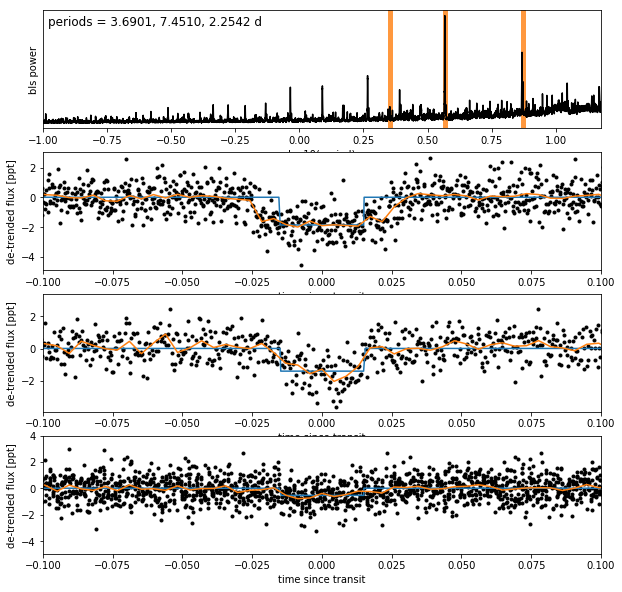

In [8]:
fig, axes = plt.subplots(4, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_periods[0]), color="C1", lw=5, alpha=0.8)
ax.axvline(np.log10(bls_periods[1]), color="C1", lw=5, alpha=0.8)
ax.axvline(np.log10(bls_periods[2]), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power0.period), bls_power0.power, "k")
ax.annotate("periods = {0:.4f}, {1:.4f}, {2:.4f} d".format(*bls_periods),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transits
bls = BoxLeastSquares(time, lc.flux - pld_flux)
for i in range(3):
    ax = axes[i+1]
    x_fold = (time - bls_t0s[i] + 0.5*bls_periods[i])%bls_periods[i] - 0.5*bls_periods[i]
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], lc.flux[m] - pld_flux[m], ".k")
    inds = np.argsort(x_fold[m])
    ax.plot(x_fold[m][inds], bls.model(time, bls_periods[i], duration, bls_t0s[i])[m][inds])

    # Overplot the phase binned light curve
    bins = np.linspace(-0.11, 0.11, 52)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=lc.flux - pld_flux)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.1, 0.1)
    ax.set_ylabel("de-trended flux [ppt]")
    ax.set_xlabel("time since transit");

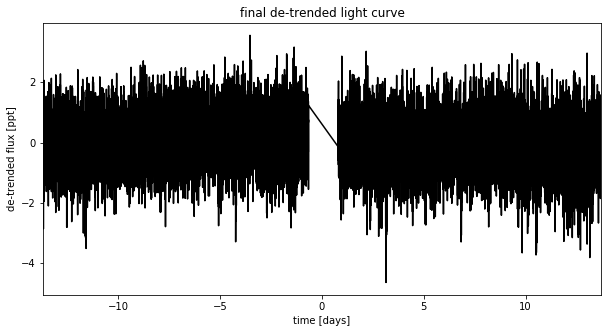

In [9]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, lc.flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(lc.time-ref_time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(x, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(x.min(), x.max());



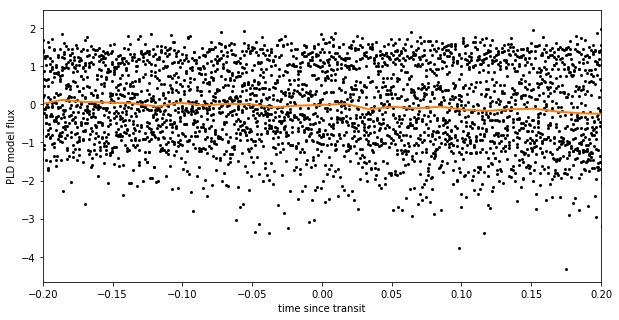

In [10]:
plt.figure(figsize=(10, 5))

x_fold = (x - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.3
plt.plot(x_fold[m], pld_flux[m], ".k", ms=4)

bins = np.linspace(-0.5, 0.5, 60)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=pld_flux)
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1", lw=2)
plt.xlim(-0.2, 0.2)
plt.xlabel("time since transit")
plt.ylabel("PLD model flux");

In [11]:
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.3, 0.2]))
        
        # Stellar parameters from Kostov et al (2018)
        R_star_kostov = 0.291, 0.025
#         M_star_kostov = 0.32, 0.025
        Rho_star_kostov = 18.0
#         m_star = pm.Normal("m_star", mu=M_star_kostov[0], sd=M_star_kostov[1])
        r_star = pm.Normal("r_star", mu=R_star_kostov[0], sd=R_star_kostov[1])

        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star_kostov), sd=0.1)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))

        # Prior to require physical parameters
#         pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
#         pm.Potential("rho_star_prior", tt.switch(rho_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_periods), sd=0.1, shape=3)
        t0 = pm.Normal("t0", mu=bls_t0s, sd=0.1, shape=3)
        logror = pm.Normal("logror", mu=np.log(np.sqrt(1e-3)*np.sqrt(bls_depths)),
                           sd=2, shape=3)
        ror = pm.Deterministic("r", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=[0,0.3,0], upper=[0.8,1,0.8], shape=3)
        b = pm.Deterministic("b", b_param * (1 + ror))
#         ror, b = xo.distributions.get_joint_radius_impact(
#             min_radius=0.01, max_radius=0.3,
#             testval_r=np.sqrt(1e-3)*np.sqrt(bls_depths),
#             testval_b=[0.1,0.8,0.1])
        ecc = pm.Bound(pm.Beta, lower=0.0, upper=0.8)("ecc", alpha=0.867, beta=3.03,
                                                       testval=[0.1,0.1,0.1], shape=3)
#         ecc = pm.Beta('ecc', alpha=0.867, beta=3.03, testval=[0.03,0.02,0.04], shape=3)
        omega = xo.distributions.Angle("omega", shape=3)
        
        # Log-uniform prior on ror
        pm.Potential("ror_prior_lo", tt.switch(tt.all(0.005 < ror), 0.0, -np.inf))
        pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))
#         pm.Potential("ror_prior", -tt.log(ror))

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logS0 = pm.Normal("logS0", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=np.log(2*np.pi/10), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        r_ple = pm.Deterministic("r_ple", (r_star * ror / 0.009155))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, #m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega,
            rho_star=rho_star,
            )
        
        a = pm.Deterministic("a", orbit.a)
        pm.Potential("ecc_prior", tt.switch((ecc < 1 - (1/a)), 0, -np.inf))

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curves

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve - mean))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[logs2, logS0, logw0])
#         map_soln = pm.find_MAP(start=map_soln, vars=[model.rb])
        map_soln = xo.optimize(start=map_soln, vars=[model.logror, model.b_param])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

success: True
initial logp: -22767.0928916575
final logp: -22712.62463206788


/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

success: False
initial logp: -22712.62463206788
final logp: -22645.333489806522


/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


success: False
initial logp: -22645.333489806526
final logp: -22619.305150540433


/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


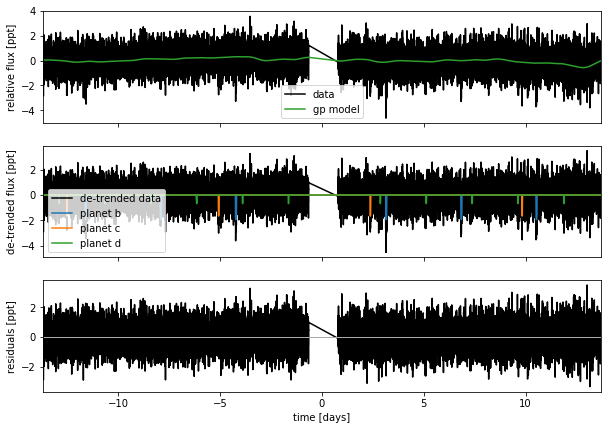

In [12]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.gp_pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curves = xo.utils.eval_in_model(model.light_curves, soln, model=model)
    for i, l in enumerate(["b", "c", 'd']):
        mod = light_curves[:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(light_curves, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);


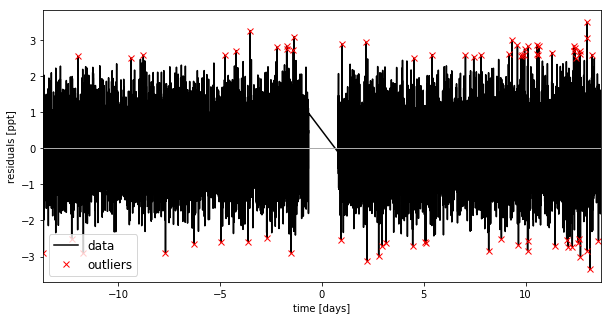

In [13]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 4.5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

success: True
initial logp: -22170.30620195365
final logp: -22162.92601452819
success: True
initial logp: -22162.92601452819
final logp: -22162.85092768297


/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

success: False
initial logp: -22162.850927682968
final logp: -22162.666259825168


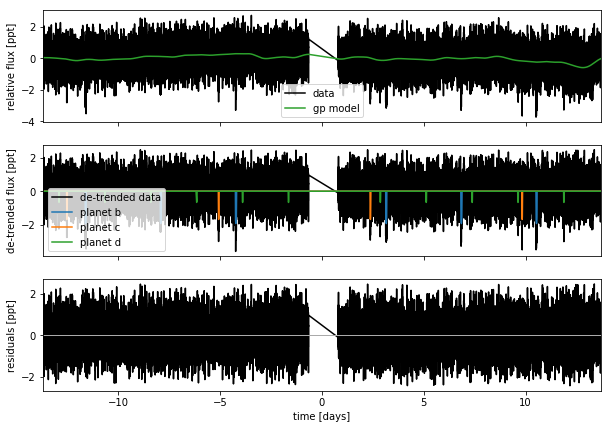

In [14]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(model, map_soln, mask);

In [23]:
sampler = xo.PyMC3Sampler(window=200, start=500, finish=500)
with model:
    burnin = sampler.tune(tune=6000, start=map_soln, step_kwargs=dict(target_accept=0.9))

Sampling 4 chains: 100%|██████████| 2008/2008 [20:42<00:00,  1.11s/draws]


In [24]:
with model:
    trace = sampler.sample(draws=4000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logw0, logS0, logs2, omega, ecc, b_param, logror, t0, logP, logrho_star, r_star, u_star, mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [1:38:07<00:00,  1.48s/draws]  
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8367431162080836, but should be close to 0.9. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7590900858473139, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [25]:
pm.summary(trace, varnames= ['b_param', 'logror', 't0', 'logP', 'ecc', 'omega',
           'logrho_star', 'r_star', 'u_star',  'logw0', 'logS0',
                             'logs2', 'mean', 'r_ple', 'rho_star'], )

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b_param__0,0.259126,0.183211,3.467934e-03,0.000011,0.619871,3644.864856,1.001815
b_param__1,0.804333,0.099123,1.758223e-03,0.567133,0.926261,3183.931854,1.001043
b_param__2,0.319246,0.185118,2.850849e-03,0.000025,0.632486,5227.339515,1.000521
logror__0,-3.195512,0.032938,7.394596e-04,-3.262027,-3.133961,1593.654535,1.006990
logror__1,-3.143986,0.076897,2.002469e-03,-3.281785,-3.014524,1443.276147,1.000867
logror__2,-3.792395,0.054672,5.673078e-04,-3.905008,-3.690076,10532.828592,1.000075
t0__0,-0.535062,0.000430,5.171598e-06,-0.535876,-0.534149,7418.210699,0.999926
t0__1,-5.073223,0.000730,6.413911e-06,-5.074736,-5.071860,14091.961191,1.000223
t0__2,-1.639762,0.001129,1.848761e-05,-1.641946,-1.637481,4908.274918,1.000198
logP__0,1.305798,0.000048,6.042848e-07,1.305700,1.305891,8695.312988,1.000403


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feb3d34c2e8>,
      dtype=object)

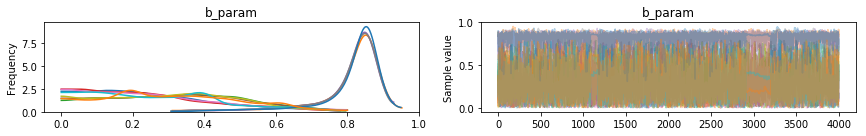

In [26]:
pm.traceplot(trace, varnames=["b_param"])

GridSpec(1, 2, width_ratios=[3, 1])

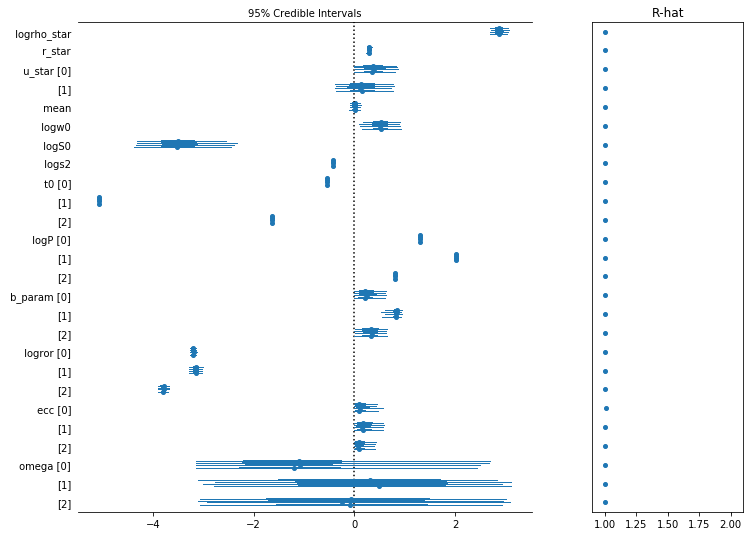

In [19]:
fig = plt.figure(figsize=[12,8])
pm.forestplot(trace, varnames=["logrho_star", "r_star", "u_star", "mean", "logw0", "logS0", "logs2", 
                               "t0", "logP", "b_param", "logror", "ecc", "omega"])

In [38]:
trace["b"][:,0]

array([0.46689968, 0.15409866, 0.45513778, ..., 0.12773726, 0.17383682,
       0.10665085])

In [23]:
q = pm.summary(trace, varnames= ['logrho_star', 'u_star', 'r_star', 
                             't0', 'logP', 'period', 'b', 'logror', 'ecc', 'omega', 'r',
                                'a', 'r_ple'], alpha=0.1, )

In [138]:
$\ln{Period [days]}$ & 0.81208 & 0.81232 & 0.81255 \\
Impact parameter & 0.00 & 0.36 & 0.63 \\
$\ln{R_p/R_s}$ & -3.90 & -3.80 & -3.70 \\
ecentricity & 0.00 & 0.17 & 0.38 \\
$\omega$ & -2.6 & 0.0 & 3.2 \\

$\ln{Period [days]}$ & 1.30569 & 1.30578 & 1.30587 \\
Impact parameter & 0.00 & 0.32 & 0.60 \\
$\ln{R_p/R_s}$ & -3.27 & -3.20 & -3.14 \\
ecentricity & 0.00 & 0.17 & 0.39 \\
$\omega$ & -3.1 & -0.5 & 2.3 \\

$\ln{Period [days]}$ & 2.0083 & 2.0084 & 2.0086 \\
Impact parameter & 0.78 & 0.90 & 1.04 \\
$\ln{R_p/R_s}$ & -3.3 & -3.1 & -2.9 \\
ecentricity & 0.00 & 0.19 & 0.47 \\
$\omega$ & -3.1 & 0.1 & 2.6 \\

SyntaxError: invalid syntax (<ipython-input-138-75b5d56ce806>, line 1)

In [25]:
q.loc[['r__1', 'r_ple__1', 'a__1', ], ['hpd_5', 'mean', 'hpd_95']]

,hpd_5,mean,hpd_95
r__1,0.038017,0.043847,0.047950
r_ple__1,1.109971,1.394958,1.620511
a__1,8.968483,10.779794,12.565777


In [97]:
ref_time + q.loc[['t0__1', ], ['hpd_5', 'mean', 'hpd_95']]

,hpd_5,mean,hpd_95
t0__1,1362.736148,1362.73748,1362.738738


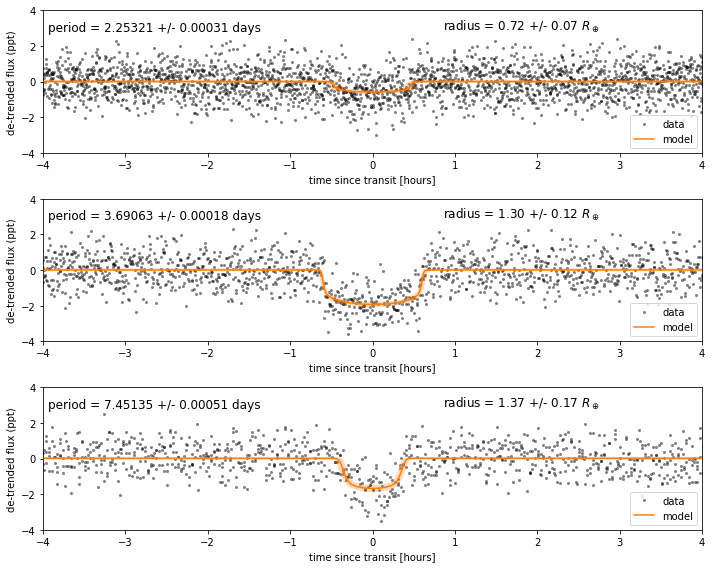

In [27]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] , axis=0)


fig,  axes = plt.subplots(3,1, figsize=[10, 8])
for i, pnum in enumerate([2,0,1]):
    ax1 = axes[i]
    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:,pnum])
    t0 = np.median(trace['t0'][:,pnum])

    # Plot the folded data

    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    ax1.plot(x_fold * 24., y[mask] - gp_mod, ".k", label="data",
             alpha=0.5, zorder=-1000, mec="none")

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = np.add(trace['mean'], trace["light_curve"][:, inds].T ).T
    pred = np.percentile(pred, [5, 50, 95], axis=0)
    ax1.plot(x_fold[inds] * 24., pred[1], color="C1", label="model")
    art = ax1.fill_between(x_fold[inds] * 24., pred[0], pred[2], color="C1", alpha=0.3,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.5f} +/- {1:.5f} days".format(
        np.mean(trace["period"][:,pnum]), np.std(trace["period"][:,pnum]))

    ax1.annotate(txt, (0, 0.8), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)
    txt = "radius = {0:.2f} +/- {1:.2f} $R_\oplus$".format(
        np.mean(trace["r_ple"][:,pnum]), np.std(trace["r_ple"][:,pnum]))
    ax1.annotate(txt, (0.6, 0.8), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)


    ax1.legend(fontsize=10, loc=4)
    ax1.set_xlabel("time since transit [hours]")
    ax1.set_ylabel("de-trended flux (ppt)")
    ax1.set_xlim(-4, 4);
    ax1.set_ylim(-4, 4);

plt.tight_layout()
# plt.savefig('l98-transit-plot2.png', dpi=200)

In [156]:
np.add(trace['mean'], trace["light_curve"][:, inds].T ).T

array([[-0.02943607, -0.02943607, -0.02943607, ..., -0.02943607,
        -1.86434453, -0.02943607],
       [-0.0501847 , -0.0501847 , -0.0501847 , ..., -0.0501847 ,
        -1.79435563, -0.0501847 ],
       [ 0.03359596,  0.03359596,  0.03359596, ...,  0.03359596,
        -1.72348364,  0.03359596],
       ...,
       [ 0.14473386,  0.14473386,  0.14473386, ...,  0.14473386,
        -1.61730876,  0.14473386],
       [ 0.0691863 ,  0.0691863 ,  0.0691863 , ...,  0.0691863 ,
        -1.87243347,  0.0691863 ],
       [-0.0715991 , -0.0715991 , -0.0715991 , ..., -0.0715991 ,
        -1.98908104, -0.0715991 ]])

In [142]:
np.log(np.sqrt(1e-3)*np.sqrt(bls_depths))

array([-3.13973086, -3.27520249, -3.73567897])

In [21]:
start, step = sampler._get_start_and_step()
with model:
    step = pm.NUTS(potential=step.potential, target_accept=0.9)
    trace = pm.sample(draws=5000, tune=200, step=step, start=start)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logw0, logS0, logs2, omega, ecc, b_param, logror, t0, logP, logrho_star, r_star, u_star, mean]
Sampling 4 chains: 100%|██████████| 20800/20800 [4:41:49<00:00,  1.65s/draws]  
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [22]:
pm.summary(trace, varnames= ['b_param', 'logror', 't0', 'logP', 'ecc', 'omega',
           'logrho_star', 'r_star', 'u_star',  'logw0', 'logS0',
                             'logs2', 'mean', 'r_ple', 'rho_star'], )

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b_param__0,0.257939,0.180081,2.542262e-03,1.814995e-05,0.615969,4599.572295,1.000286
b_param__1,0.795899,0.107435,2.535892e-03,5.224344e-01,0.928427,1880.008335,1.001495
b_param__2,0.313019,0.182837,2.266434e-03,3.613948e-05,0.631174,6172.113277,1.000487
logror__0,-3.201175,0.033005,3.695750e-04,-3.269114e+00,-3.139965,6048.766270,1.000241
logror__1,-3.138866,0.098160,3.159401e-03,-3.288643e+00,-3.008458,953.224195,1.000367
logror__2,-3.790784,0.055596,5.990262e-04,-3.903826e+00,-3.686784,9308.174254,1.000219
t0__0,-0.535579,0.000563,5.810427e-06,-5.366121e-01,-0.534487,9358.609959,0.999944
t0__1,-5.073224,0.000747,6.582006e-06,-5.074729e+00,-5.071802,13881.577154,1.000289
t0__2,-1.639982,0.001135,1.662097e-05,-1.642212e+00,-1.637764,4504.828195,1.000794
logP__0,1.305738,0.000060,6.180285e-07,1.305623e+00,1.305851,10918.219804,1.000270


In [23]:
pm.save_trace(trace)

'.pymc_1.trace'

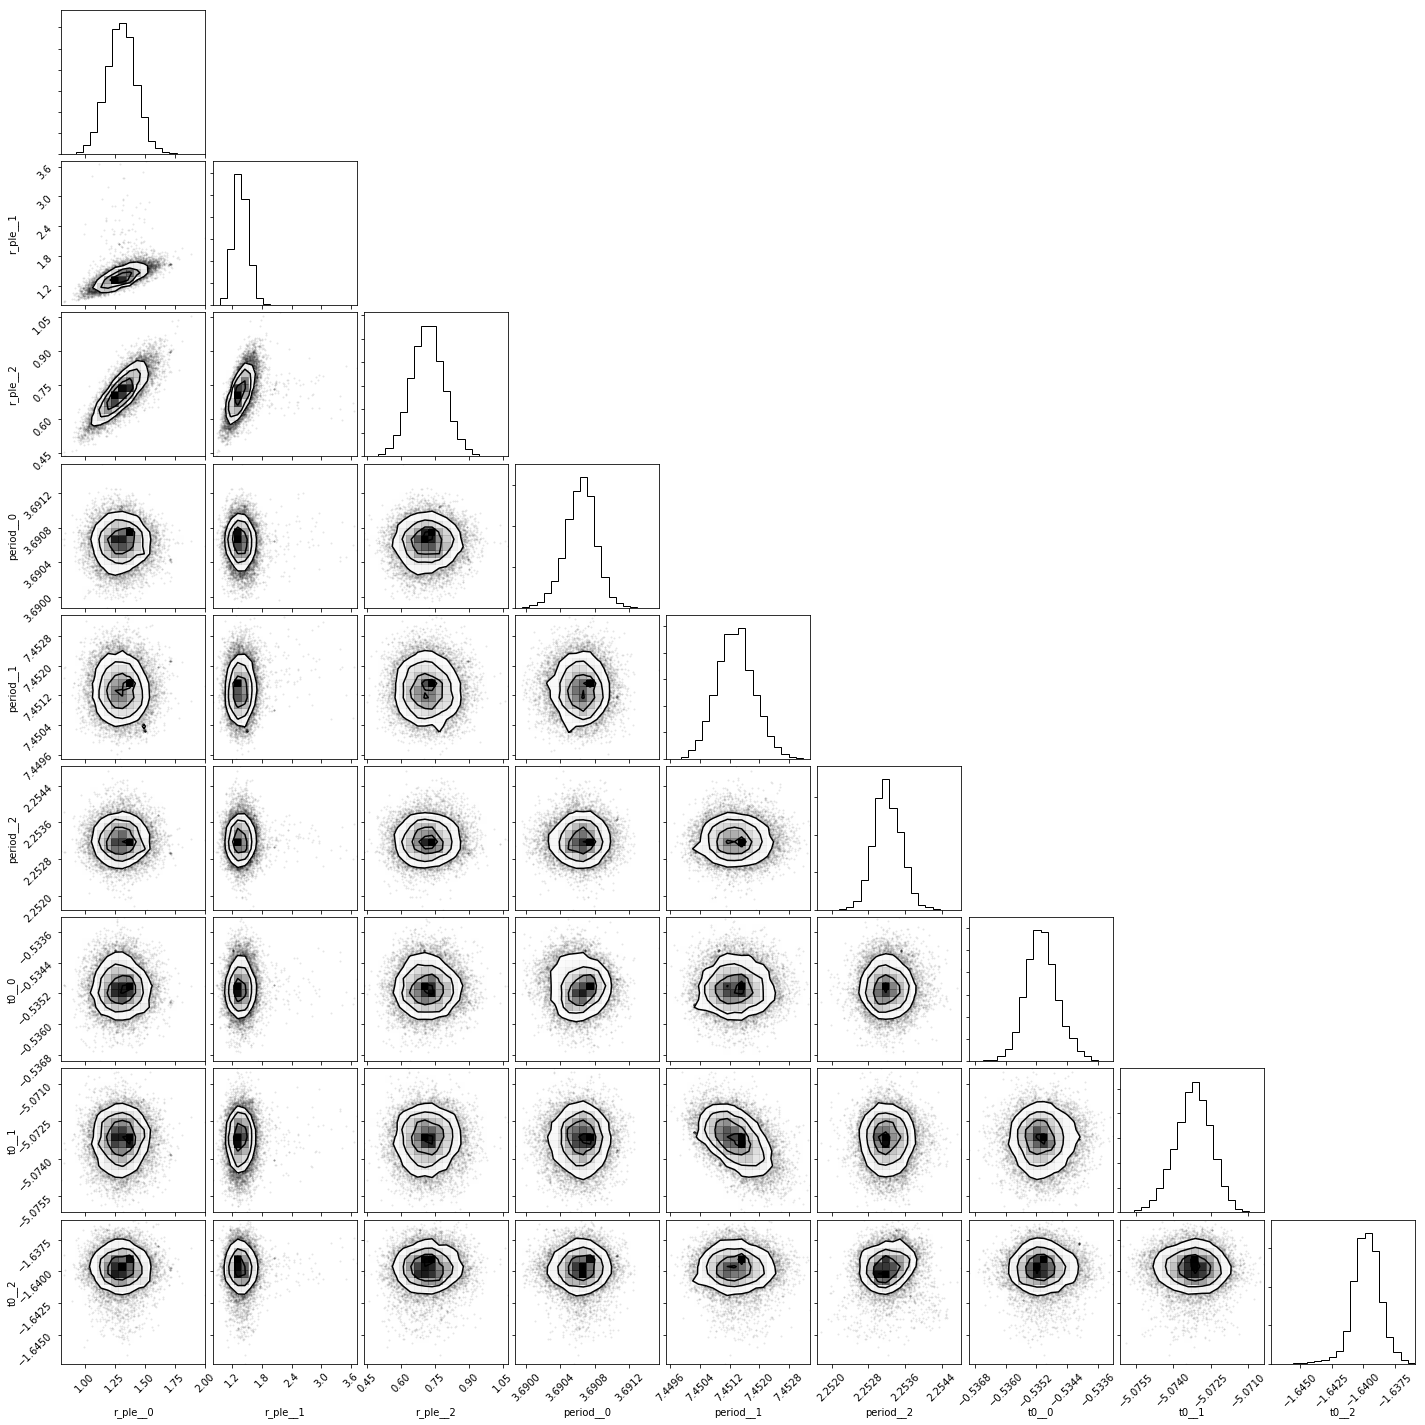

In [28]:
import corner
varnames = ["r_ple", "period", 't0']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);

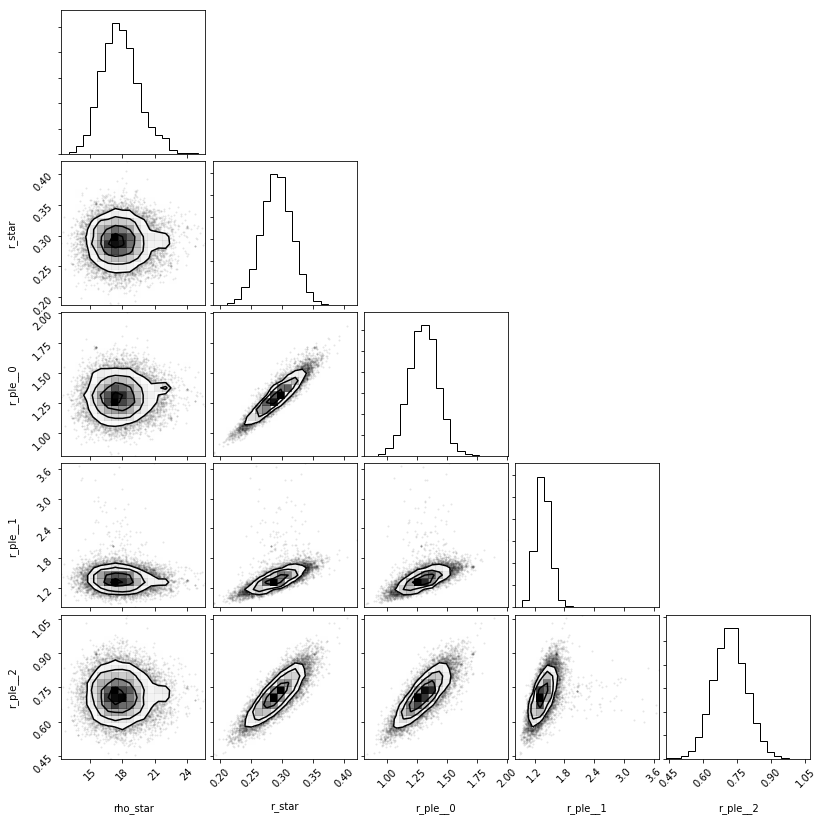

In [37]:

import corner
varnames = ["rho_star", "r_star", 'r_ple']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);

(14000, 16000)

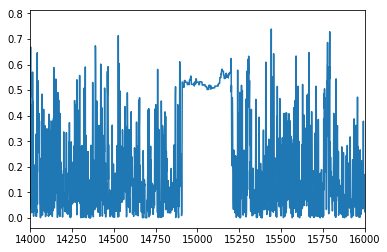

In [35]:
plt.plot(samples.ecc__0)
plt.xlim(14000,16000)